<a href="https://colab.research.google.com/github/Suchitra-V31/OPENCV/blob/main/Panorama_Stictching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Panorama Stictching**

First we need to import all the necessary libraries.

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import imageio
cv2.ocl.setUseOpenCL(False)

In [23]:
train_img=imageio.imread('/content/panroma_1.jpg')
train_img_grey=cv2.cvtColor(train_img,cv2.COLOR_RGB2GRAY)

In [26]:
query_img=imageio.imread('/content/panroma-2.jpg')
query_img_grey=cv2.cvtColor(query_img,cv2.COLOR_RGB2GRAY)


Text(0.5, 0, 'Train image')

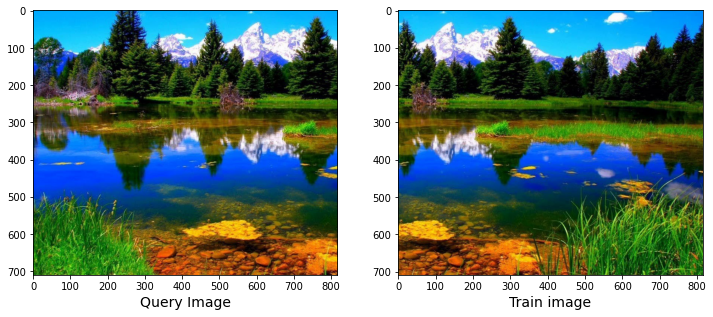

In [31]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(12,5))
ax1.imshow(query_img,cmap='gray')
ax1.set_xlabel('Query Image',fontsize=14)

ax2.imshow(train_img,cmap='gray')
ax2.set_xlabel('Train image',fontsize=14)

**STEP-1:** Detect Keypoints

In [41]:
method_used='brisk'

In [40]:
def detectAndDescribe(image,method=None):
  descriptor=cv2.BRISK_create()
  (kps,features)=descriptor.detectAndCompute(image,None)
  return(kps,features)

In [44]:
(kpsA,featuresA)=detectAndDescribe(train_img_grey,method_used)
(kpsB,featuresB)=detectAndDescribe(query_img_grey,method_used)

Text(0.5, 0, 'Query Image Keypoints')

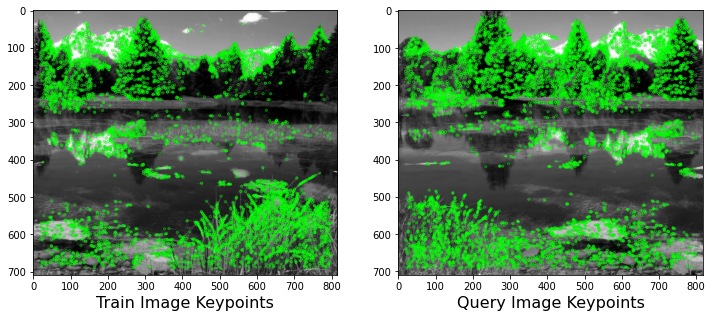

In [47]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,constrained_layout=False,figsize=(12,5))
ax1.imshow(cv2.drawKeypoints(train_img_grey,kpsA,None,(0,255,0)))
ax1.set_xlabel('Train Image Keypoints',fontsize=16)
ax2.imshow(cv2.drawKeypoints(query_img_grey,kpsB,None,(0,255,0)))
ax2.set_xlabel('Query Image Keypoints',fontsize=16)

**STEP-2:** Match the descriptors between 2 images

In [56]:
feature_matching='bf'

In [63]:
def createMatcher(method,crossCheck):
  bf=cv2.BFMatcher(cv2.NORM_HAMMING,crossCheck=crossCheck)
  return bf

In [64]:
def matchKeypointsBF(featuresA,featuresB,method):
  bf=createMatcher(method_used,crossCheck=True)
  bf_match=bf.match(featuresA,featuresB)
  raw_matches=sorted(bf_match,key=lambda x:x.distance)
  print('Raw Matches: ',len(raw_matches))
  return raw_matches

Using: bf feature matcher
Raw Matches:  2762


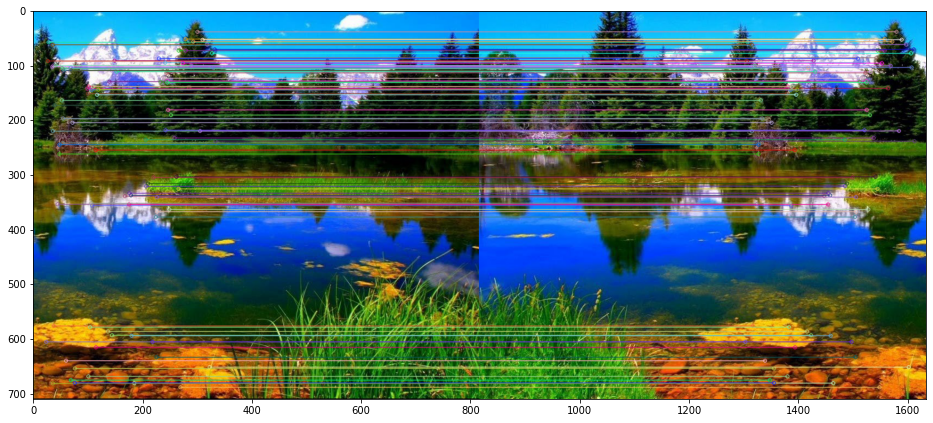

In [66]:
print("Using: {} feature matcher".format(feature_matching))
fig=plt.figure(figsize=(16,9))
matches=matchKeypointsBF(featuresA,featuresB,method=method_used)
img3=cv2.drawMatches(train_img,kpsA,query_img,kpsB,matches[:100],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.show()

**STEP-3:** Get Homography

In [69]:
def getHomography(kpsA,kpsB,featuresA,featuresB,reprojThresh):
  kpsA=np.float32([kp.pt for kp in kpsA])
  kpsB=np.float32([kp.pt for kp in kpsB])
  if len(matches)>4:
      pts1=np.float32([kpsA[m.queryIdx] for m in matches])
      pts2=np.float32([kpsB[m.trainIdx] for m in matches])
      (H,status)=cv2.findHomography(pts1,pts2,cv2.RANSAC,reprojThresh)
      return(matches,H,status)
  else:
    return None


In [70]:
M=getHomography(kpsA,kpsB,featuresA,featuresB,reprojThresh=4)
if M is None:
  print('ERROR!!!')
(matches,H,status)=M
print(H)

[[ 9.98347468e-01 -6.24809688e-04  4.62958596e+02]
 [-7.03566590e-05  9.99448068e-01  2.68321268e-02]
 [-1.08844158e-06 -5.23239567e-07  1.00000000e+00]]


In [71]:
# Apply panorama correction
width = train_img.shape[1] + query_img.shape[1]
height = train_img.shape[0] + query_img.shape[0]


result = cv2.warpPerspective(train_img, H, (width, height))
result[0:query_img.shape[0], 0:query_img.shape[1]] = query_img

In [74]:
(query_img.shape[0],query_img.shape[1])

(710, 818)

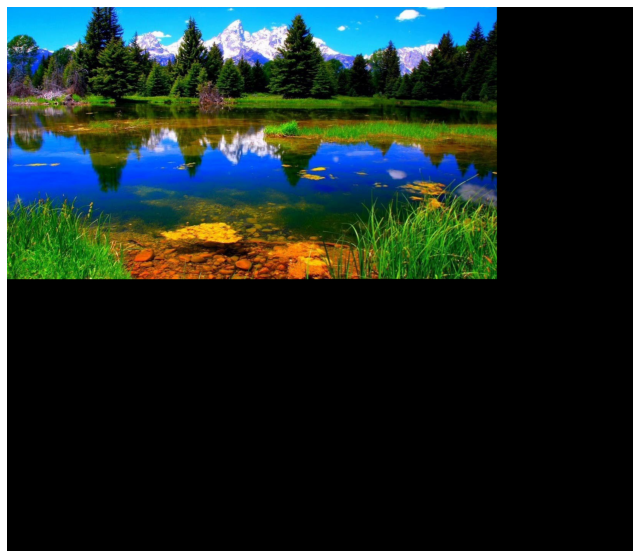

In [75]:
plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

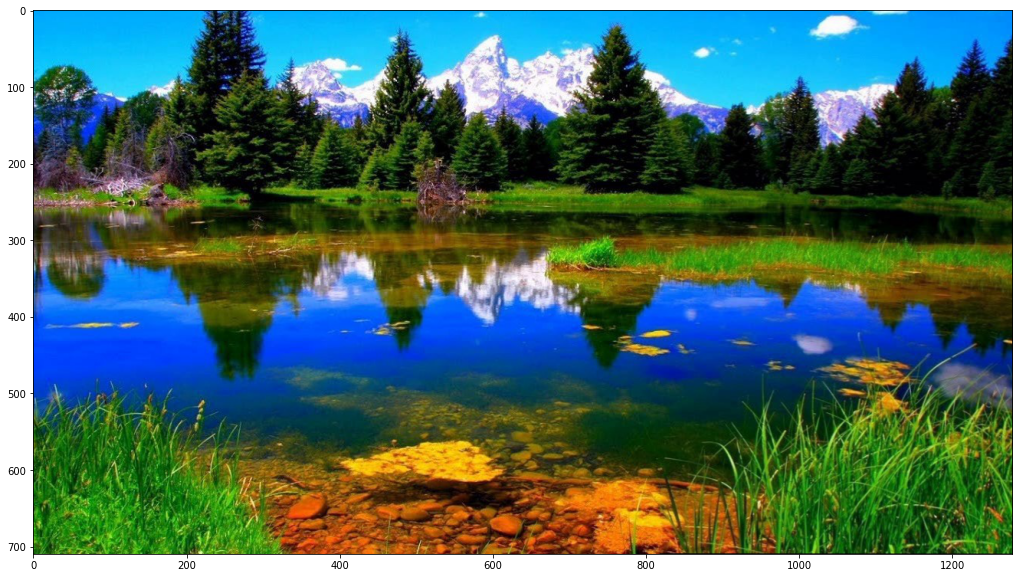

In [76]:
# transform the panorama image to grayscale and threshold it 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

So we got the Panoramic Image.